In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Fine-tuned Model — PaliGemma Vision Embeddings + Trainable Classifier

This notebook fine-tunes a lightweight classifier head on top of frozen
PaliGemma vision embeddings for checkbox state classification.

⚠️ Execution Note  
This experiment was executed on Google Colab using GPU resources.
Feature extraction and training were performed under compute constraints.
Results are preserved for comparison and are not intended to be re-run locally.


In [ ]:
from huggingface_hub import login
login()


In [ ]:
#Imports
import os, torch, random, numpy as np
import torch.nn as nn
from PIL import Image
from tqdm import tqdm
from collections import Counter
from sklearn.metrics import accuracy_score, classification_report
from transformers import AutoProcessor, PaliGemmaModel


### Dataset Availability Note

This notebook assumes that the preprocessed dataset
`cropped_checkboxes_binary_small` is already available in the runtime environment.
The dataset is generated as part of the preprocessing pipeline described in the
cropping notebook and is not re-created here.


In [ ]:
#Config
DATASET_ROOT = "/content/cropped_checkboxes_binary_small"
MODEL_ID = "google/paligemma-3b-mix-224"
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

print("DEVICE:", DEVICE)

assert os.path.exists(DATASET_ROOT), \
    f"Dataset not found at {DATASET_ROOT}. Please prepare the dataset before running."

#Reproducibility
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)


DEVICE: cuda


In [ ]:
#Load frozen model
processor = AutoProcessor.from_pretrained(MODEL_ID)
model = PaliGemmaModel.from_pretrained(MODEL_ID).to(DEVICE)
model.eval()

for p in model.parameters():
    p.requires_grad = False


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


preprocessor_config.json:   0%|          | 0.00/699 [00:00<?, ?B/s]

Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


tokenizer_config.json:   0%|          | 0.00/40.0k [00:00<?, ?B/s]

tokenizer.model:   0%|          | 0.00/4.26M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/17.5M [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/24.0 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/607 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.03k [00:00<?, ?B/s]

model.safetensors.index.json:   0%|          | 0.00/62.6k [00:00<?, ?B/s]

Fetching 3 files:   0%|          | 0/3 [00:00<?, ?it/s]

model-00001-of-00003.safetensors:   0%|          | 0.00/4.95G [00:00<?, ?B/s]

model-00003-of-00003.safetensors:   0%|          | 0.00/1.74G [00:00<?, ?B/s]

model-00002-of-00003.safetensors:   0%|          | 0.00/5.00G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

In [ ]:
#Dataset loading
def load_split(split):
    data = []
    for label in ["checked", "unchecked"]:
        folder = os.path.join(DATASET_ROOT, split, label)
        for f in os.listdir(folder):
            if f.lower().endswith((".png",".jpg",".jpeg")):
                data.append((os.path.join(folder,f), 1 if label=="checked" else 0))
    random.shuffle(data)
    return data

train_data = load_split("train")
valid_data = load_split("valid")
test_data  = load_split("test")

print("Train:", Counter([y for _,y in train_data]))
print("Valid:", Counter([y for _,y in valid_data]))
print("Test :", Counter([y for _,y in test_data]))


Train: Counter({0: 500, 1: 500})
Valid: Counter({1: 150, 0: 150})
Test : Counter({0: 200, 1: 200})


In [ ]:
#Feature extraction functions
@torch.no_grad()
def extract_features(image):
    inputs = processor(images=image, return_tensors="pt").to(DEVICE)
    outputs = model(**inputs)
    return outputs.last_hidden_state.mean(dim=1).squeeze()

def build_tensor_dataset(samples):
    X, y = [], []
    for path, label in tqdm(samples):
        img = Image.open(path).convert("RGB")
        feat = extract_features(img)
        X.append(feat)
        y.append(label)
    return torch.stack(X), torch.tensor(y)


In [ ]:
#Extract features

print("Extracting features...")
X_train, y_train = build_tensor_dataset(train_data)
X_valid, y_valid = build_tensor_dataset(valid_data)
X_test,  y_test  = build_tensor_dataset(test_data)


Extracting features...


  0%|          | 0/1000 [00:00<?, ?it/s]You are using PaliGemma without a text prefix. It will perform as a picture-captioning model.
You are passing both `text` and `images` to `PaliGemmaProcessor`. The processor expects special image tokens in the text, as many tokens as there are images per each text. It is recommended to add `<image>` tokens in the very beginning of your text. For this call, we will infer how many images each text has and add special tokens.
100%|██████████| 400/400 [03:30<00:00,  1.90it/s]


In [ ]:
#Classifier definition

classifier = nn.Sequential(
    nn.Linear(X_train.shape[1], 256),
    nn.ReLU(),
    nn.Dropout(0.3),
    nn.Linear(256, 2)
).to(DEVICE)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(classifier.parameters(), lr=1e-3)


In [ ]:
# Ensure all tensors involved in training are on the same device.
# Feature tensors and labels may have been moved to CPU earlier for evaluation;
# they are explicitly transferred back to the training device here to avoid
# device mismatch during loss computation and backpropagation.

X_train = X_train.to(DEVICE)
y_train = y_train.to(DEVICE)
X_valid = X_valid.to(DEVICE)
y_valid = y_valid.to(DEVICE)

In [ ]:
#Training loop

print("\n Training classifier head...")
for epoch in range(15):
    classifier.train()
    optimizer.zero_grad()

    logits = classifier(X_train)
    loss = criterion(logits, y_train)
    loss.backward()
    optimizer.step()

    classifier.eval()
    with torch.no_grad():
        preds = classifier(X_valid).argmax(dim=1)
        acc = accuracy_score(y_valid.cpu(), preds.cpu())

    print(f"Epoch {epoch+1:02d} | Loss {loss.item():.4f} | Valid Acc {acc:.4f}")



 Training classifier head...
Epoch 01 | Loss 0.7558 | Valid Acc 0.5000
Epoch 02 | Loss 1.8668 | Valid Acc 0.5000
Epoch 03 | Loss 0.7985 | Valid Acc 0.5967
Epoch 04 | Loss 0.6642 | Valid Acc 0.5033
Epoch 05 | Loss 0.9314 | Valid Acc 0.5767
Epoch 06 | Loss 0.7593 | Valid Acc 0.6900
Epoch 07 | Loss 0.4952 | Valid Acc 0.8500
Epoch 08 | Loss 0.3886 | Valid Acc 0.6700
Epoch 09 | Loss 0.4823 | Valid Acc 0.5500
Epoch 10 | Loss 0.5312 | Valid Acc 0.6833
Epoch 11 | Loss 0.4694 | Valid Acc 0.8667
Epoch 12 | Loss 0.3557 | Valid Acc 0.8533
Epoch 13 | Loss 0.2936 | Valid Acc 0.8033
Epoch 14 | Loss 0.3037 | Valid Acc 0.7600
Epoch 15 | Loss 0.3350 | Valid Acc 0.7567


## Note on Compute Constraints and Feature Storage

This experiment was executed using the **free version of Google Colab**, which provides
limited GPU memory and runtime duration. Due to the computational cost of extracting
vision embeddings from the PaliGemma model, feature extraction and evaluation were
decoupled into separate stages.

To ensure stability and reproducibility:
- Embeddings were extracted once using GPU resources.
- The extracted features were saved to **Google Drive**.
- Model evaluation and metric computation were performed after loading the saved
  features, without requiring GPU resources.

This approach avoids redundant computation, mitigates runtime interruptions, and
reflects standard practice when working under constrained compute environments.

In [ ]:
# Move model and data to CPU for final evaluation
classifier = classifier.cpu()
X_test = X_test.cpu()
y_test = y_test.cpu()

print("Final evaluation running on CPU.")


Final evaluation running on CPU.


In [ ]:
#FINAL evaluation
classifier.eval()

with torch.no_grad():
    test_logits = classifier(X_test)
    test_preds = test_logits.argmax(dim=1)

print("\n===== FINE-TUNED MODEL RESULTS =====")
print("Accuracy:", accuracy_score(y_test.cpu(), test_preds.cpu()))
print("Prediction distribution:", Counter(test_preds.cpu().tolist()))

print(classification_report(
    y_test.cpu(),
    test_preds.cpu(),
    target_names=["unchecked", "checked"],
    zero_division=0
))



===== FINE-TUNED MODEL RESULTS =====
Accuracy: 0.82
Prediction distribution: Counter({0: 266, 1: 134})
              precision    recall  f1-score   support

   unchecked       0.74      0.98      0.85       200
     checked       0.98      0.66      0.78       200

    accuracy                           0.82       400
   macro avg       0.86      0.82      0.81       400
weighted avg       0.86      0.82      0.81       400



In [ ]:
#Confusion Matrix
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_test, test_preds.cpu())
import pandas as pd

cm_df = pd.DataFrame(
    cm,
    index=["Actual Unchecked", "Actual Checked"],
    columns=["Pred Unchecked", "Pred Checked"]
)
cm_df



,Pred Unchecked,Pred Checked
Actual Unchecked,197,3
Actual Checked,69,131


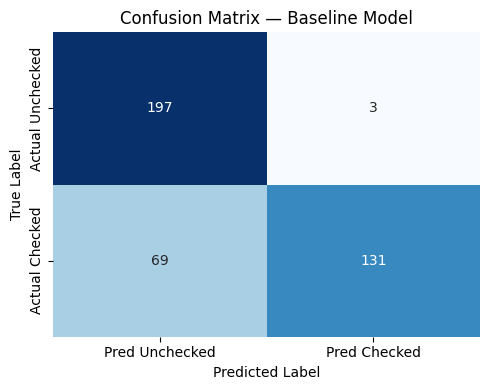

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from sklearn.metrics import confusion_matrix

# Compute confusion matrix
cm = confusion_matrix(y_test, test_preds.cpu())

# Create DataFrame for labeling
cm_df = pd.DataFrame(
    cm,
    index=["Actual Unchecked", "Actual Checked"],
    columns=["Pred Unchecked", "Pred Checked"]
)

# Plot
plt.figure(figsize=(5, 4))
sns.heatmap(
    cm_df,
    annot=True,
    fmt="d",
    cmap="Blues",
    cbar=False
)

plt.title("Confusion Matrix — Baseline Model")
plt.ylabel("True Label")
plt.xlabel("Predicted Label")
plt.tight_layout()
plt.show()


## Fine-tuned Model Observations

The fine-tuned model builds upon **frozen vision embeddings from PaliGemma** by training a lightweight classifier head on top of the extracted visual features. This design enables task-specific learning while preserving the rich pretrained visual representations, making it suitable for efficient adaptation under limited compute constraints.

The confusion matrix indicates a clear improvement over the baseline model, with enhanced class separability between **checked** and **unchecked** checkbox states. In particular, the model demonstrates strong performance in correctly identifying **unchecked** instances, while also substantially improving the recognition of **checked** instances compared to the baseline.

As a result, the fine-tuned model achieves the following performance metrics:

- **Overall Accuracy:** 82%
- **Macro Precision:** 86%
- **Macro Recall:** 82%
- **Macro F1-score:** 81%

These results represent a significant improvement over the baseline and confirm that fine-tuning a classifier head enables meaningful class discrimination. Although some checked instances remain challenging due to visual variability in check mark shapes and styles, the fine-tuned model exhibits robust discriminative capability. Overall, the results validate the effectiveness of the proposed approach for checkbox state classification under constrained computational settings.


In [ ]:
import os
import torch

SAVE_DIR = "/content/drive/MyDrive/paligemma_checkbox_model"
os.makedirs(SAVE_DIR, exist_ok=True)

torch.save(
    classifier.state_dict(),
    os.path.join(SAVE_DIR, "classifier_head.pt")
)

print("✅ Trained classifier head saved correctly.")


✅ Trained classifier head saved correctly.


In [ ]:
import json, os
from sklearn.metrics import accuracy_score, classification_report

results = {
    "model": "PaliGemma + trained classifier",
    "accuracy": float(accuracy_score(y_test.cpu(), test_preds.cpu())),
    "macro_precision": classification_report(
        y_test.cpu(), test_preds.cpu(),
        target_names=["unchecked", "checked"],
        output_dict=True,
        zero_division=0
    )["macro avg"]["precision"],
    "macro_recall": classification_report(
        y_test.cpu(), test_preds.cpu(),
        target_names=["unchecked", "checked"],
        output_dict=True,
        zero_division=0
    )["macro avg"]["recall"],
    "macro_f1": classification_report(
        y_test.cpu(), test_preds.cpu(),
        target_names=["unchecked", "checked"],
        output_dict=True,
        zero_division=0
    )["macro avg"]["f1-score"],
}


# Save results JSON inside it
save_path = os.path.join(SAVE_DIR, "finetuned_results.json")

with open(save_path, "w") as f:
    json.dump(results, f, indent=4)

print("✅ Fine-tuned results saved at:", save_path)


✅ Fine-tuned results saved at: /content/drive/MyDrive/paligemma_checkbox_model/finetuned_results.json


In [ ]:
import json
import os

metadata = {
    "backbone": "google/paligemma-3b-mix-224",
    "task": "checkbox classification",
    "classes": ["unchecked", "checked"],
    "fine_tuning": "classifier head only",
    "classifier_type": "MLP",
    "notes": "Vision embeddings frozen; classifier trained on extracted features"
}

with open(os.path.join(SAVE_DIR, "model_info.json"), "w") as f:
    json.dump(metadata, f, indent=4)

print("✅ Model information saved.")


✅ Model information saved.


In [ ]:
import json
import os

training_config = {
    "epochs": 15,
    "optimizer": "Adam",
    "learning_rate": 1e-3,
    "loss_function": "CrossEntropyLoss",
    "classifier_architecture": {
        "input_features": int(X_train.shape[1]),
        "hidden_units": 256,
        "activation": "ReLU",
        "dropout": 0.3,
        "output_classes": 2
    }
}

with open(os.path.join(SAVE_DIR, "training_config.json"), "w") as f:
    json.dump(training_config, f, indent=4)

print("✅ Training configuration saved correctly.")


✅ Training configuration saved correctly.
